In [107]:
library(io)
library(ggplot2)
library(ggpmisc)

## Helper Functions

In [124]:
#' Plot Observed vs Expected FDR with Regression and Diagonal Reference
#'
#' @param data A data frame containing the metrics.
#' @param x_col The string name of the column for the X-axis (e.g., "log(q-cut)").
#' @param y_col The string name of the column for the Y-axis (e.g., "log(1-PPV)").
#' @param x_label
#' @param y_label
#' @param group_col The string name of the column used for faceting and coloring (e.g., "dataset").
#' @param title The plot title.
#' @param point_size Size of the scatter points.
#' @param point_alpha Transparency of the scatter points.
#' @param smooth_color Color of the linear regression line.
#' @param abline_color Color of the diagonal reference line.
#' @param abline_type Line type of the diagonal reference line (e.g., "dashed", "solid").
#' @param eq_label_x Horizontal position of the regression equation (e.g., "right", "left").
#' @param eq_label_y Vertical position of the regression equation (e.g., "bottom", "top").
#' @param eq_text_size Font size of the regression equation text.
#' @param base_font_size Base font size for the theme.
#' @param force_square_limits If TRUE, calculates global min/max to ensure x and y axes have the same range.
#'
#' @return A ggplot object.
plot_fdr_comparison <- function(data, 
                                x_col = "log(q-cut)", 
                                y_col = "log(1-PPV)", 
                                group_col = "dataset",
                                title = "Observed vs Expected FDR",
								x_label = "log(q_value_cutoff)",
								y_label = "log(1-PPV)",
                                point_size = 0.5,
                                point_alpha = 0.3,
                                smooth_color = "black",
                                abline_color = "grey",
                                abline_type = "dashed",
                                eq_label_x = "right",
                                eq_label_y = "bottom",
                                eq_text_size = 3,
                                base_font_size = 15,
                                force_square_limits = TRUE) {
	
	# Initialize plot object
	p <- ggplot(data, aes(
		x = .data[[x_col]], 
		y = .data[[y_col]], 
		color = .data[[group_col]]
	))
	
	# Add Diagonal Reference Line (y=x)
	p <- p + geom_abline(slope = 1, intercept = 0, 
						color = abline_color, 
						linetype = abline_type)
	p <- p + geom_point(size = point_size, alpha = point_alpha)
	
	# Add Linear Regression Line
	p <- p + geom_smooth(method = "lm", color = smooth_color)
	p <- p + facet_wrap(as.formula(paste("~", group_col)))
	p <- p + labs(title = title, x = x_label, y = y_label)
	
	# Add Regression Equation and R-squared
	p <- p + stat_poly_eq(aes(label = paste(
								"atop(", 
								after_stat(eq.label), 
								",", 
								after_stat(rr.label), 
								")"
								)),
							formula = y ~ x, 
							parse = TRUE, 
							label.x = eq_label_x,
							label.y = eq_label_y,
							color = "black", # Keep text black for readability
							size = eq_text_size)
	
	# Add Theme
	p <- p + theme_classic(base_size = base_font_size) +
			theme(legend.position = "none")
	
	# Handle Axis Limits (Square Plot Logic)
	if (force_square_limits) {
		# Calculate global min and max across both columns to ensure 1:1 aspect ratio
		global_min <- min(c(data[[x_col]], data[[y_col]]), na.rm = TRUE)
		global_max <- max(c(data[[x_col]], data[[y_col]]), na.rm = TRUE)
		
		p <- p + xlim(global_min, global_max) +
				ylim(global_min, global_max)
	}
	
	return(p)
}


## Load Data

In [2]:
metrics <- qread("combined.tsv")

In [143]:
options(repr.plot.width = 7, repr.plot.height = 7)

## Before Calibration

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 43 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 43 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


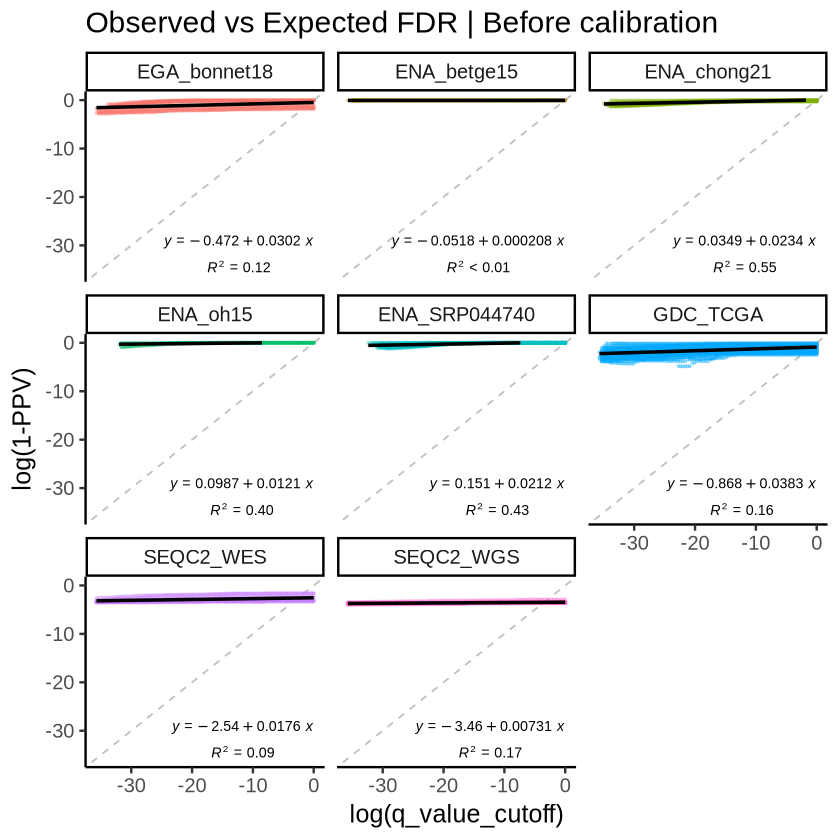

In [144]:
before_calibration <- plot_fdr_comparison(metrics, title = "Observed vs Expected FDR | Before calibration")
qdraw(before_calibration, "plots/observed-vs-expected-fdr_before-calibration.pdf", width = 7, height = 7)
before_calibration

## After Calibration

### ENA_Betge15 Excluded

Linear Regression is performed with ENA_Betge15 results removed

In [135]:
## Fit an overall linear model, excluding the ENA_betge15 dataset
metrics_cleaned <- metrics[metrics$dataset != "ENA_betge15", ]

model <- lm(`log(1-PPV)` ~ `log(q-cut)`, data = metrics_cleaned)
slope <- model$coefficients[[2]]
intercept <- model$coefficients[[1]]
metrics$`calibrated_log(q-cut)` <- slope * metrics$`log(q-cut)` + intercept

sprintf("Slope: %s", slope)
sprintf("Intercept: %s", intercept)

[1] "Slope: 0.0328658753351251"

[1] "Intercept: -0.918253396179989"

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 43 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 43 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


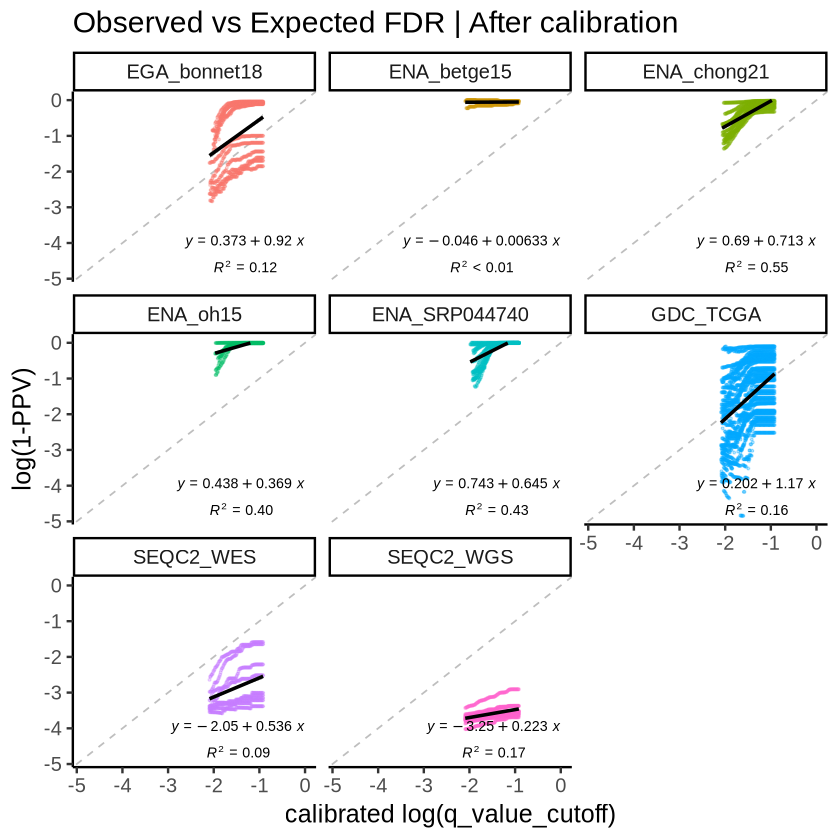

In [137]:
after_calibration <- plot_fdr_comparison(
    metrics, 
    x_col = "calibrated_log(q-cut)", 
    x_label="calibrated log(q_value_cutoff)",  
    title = "Observed vs Expected FDR | After calibration"
)
qdraw(after_calibration, "plots/observed-vs-expected-fdr_after-calibration.pdf", width = 7, height = 7)
after_calibration

### ENA_betge15 and SEQC2_WGS Excluded

In [139]:
## Fit an overall linear model, excluding the ENA_betge15 dataset and SEQC2_WGS
metrics_cleaned <- metrics[!(metrics$dataset %in% c("ENA_betge15", "SEQC2_WGS")), ]

model <- lm(`log(1-PPV)` ~ `log(q-cut)`, data = metrics_cleaned)
slope <- model$coefficients[[2]]
intercept <- model$coefficients[[1]]
metrics$`calibrated_log(q-cut)` <- slope * metrics$`log(q-cut)` + intercept

sprintf("Slope: %s", slope)
sprintf("Intercept: %s", intercept)

[1] "Slope: 0.0340785193501196"

[1] "Intercept: -0.593032356011971"

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 43 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


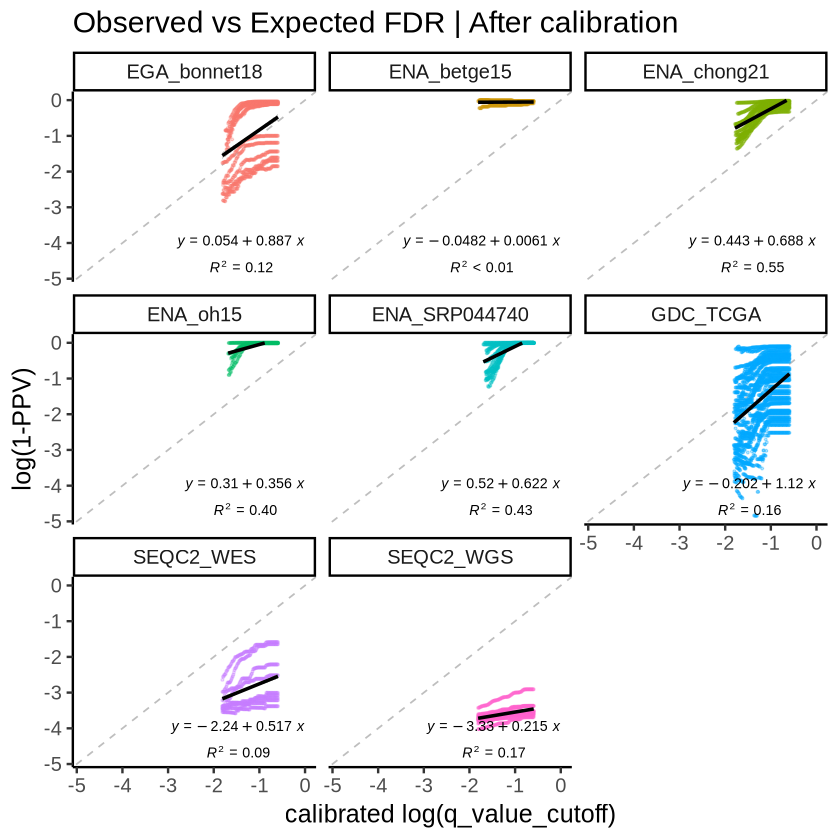

In [140]:
after_calibration <- plot_fdr_comparison(
    metrics, 
    x_col = "calibrated_log(q-cut)", 
    x_label="calibrated log(q_value_cutoff)",  
    title = "Observed vs Expected FDR | After calibration"
)
# qdraw(after_calibration, "plots/observed-vs-expected-fdr_after-calibration.pdf", width = 7, height = 7)
after_calibration

### All Datasets

In [141]:
## Fit an overall linear model, excluding the ENA_betge15 dataset and SEQC2_WGS
metrics_cleaned <- metrics

model <- lm(`log(1-PPV)` ~ `log(q-cut)`, data = metrics_cleaned)
slope <- model$coefficients[[2]]
intercept <- model$coefficients[[1]]
metrics$`calibrated_log(q-cut)` <- slope * metrics$`log(q-cut)` + intercept

sprintf("Slope: %s", slope)
sprintf("Intercept: %s", intercept)

[1] "Slope: 0.0312332506627436"

[1] "Intercept: -0.888397961206801"

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 43 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


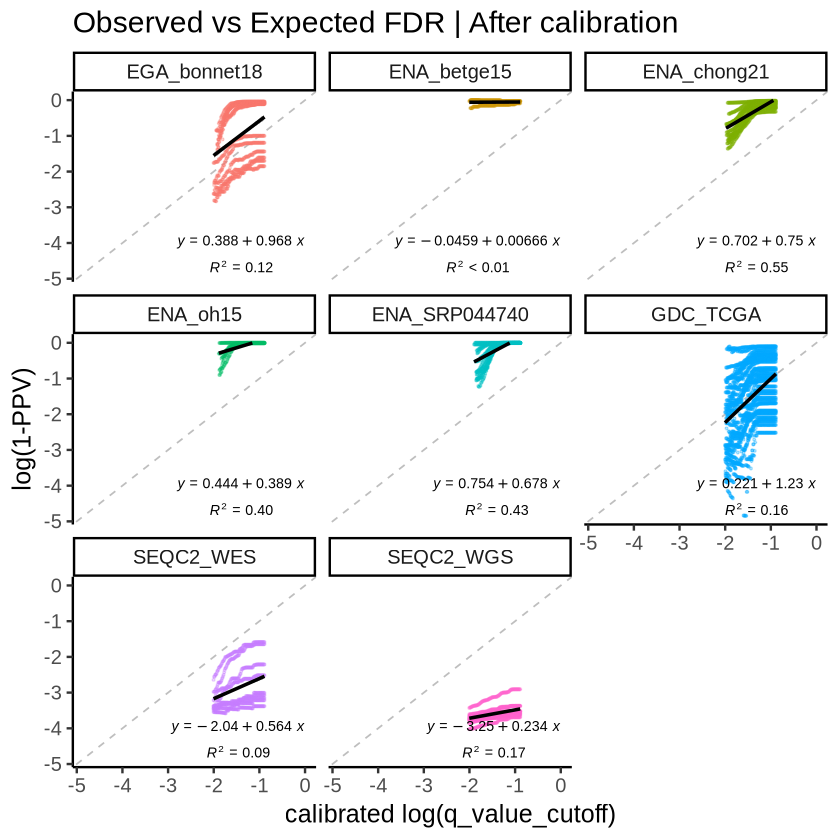

In [142]:
after_calibration <- plot_fdr_comparison(
    metrics, 
    x_col = "calibrated_log(q-cut)", 
    x_label="calibrated log(q_value_cutoff)",  
    title = "Observed vs Expected FDR | After calibration"
)
# qdraw(after_calibration, "plots/observed-vs-expected-fdr_after-calibration.pdf", width = 7, height = 7)
after_calibration